## 주식 가격 예측

### 학습 목표
- 시계열 데이터의 특성과 안정적(Stationary) 시계열의 개념을 이해한다.
- ARIMA 모델을 구성하는 AR, MA, Diffencing의 개념을 이해하고 간단한 시계열 데이터에 적용해 본다.
- 실제 주식 데이터에 ARIMA를 적용해서 예측 정확도를 확인해 본다.

### 루브릭 
-  시계열의 안정성이 충분히 확인되었는가? : **플로팅과 adfuller 메소드가 모두 적절히 사용되었음**
- ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가? : **p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨**
- 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가? : **3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨**

## 목차
### 1. 데이터 준비 및 전처리
### 2. 시계열 안정성(Stationary) 분석
#### 1) 정성적 그래프 분석
#### 2) 정량적 Augmented Dickey-Fuller Test
#### 3) 시계열 분해(Time Series Decomposition)와 Residual 안정성 확인
### 3. 적정 ARIMA 모수 찾기
### 4. ARIMA 모델 훈련과 테스트
### 5. 다른 주식 종목 예측해보기
#### 1) Amazon(3개월)
#### 2) Disney(6개월)
#### 3) Netflix(5년)
---

## 1. 데이터 준비 및 전처리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv'
df  = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates=True)
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

Series: 시간 칼럼을 index로 하는 자료구조

In [2]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

## 2. 시계열 안정성(Stationary) 분석
### 1) 정성적 그래프 분석

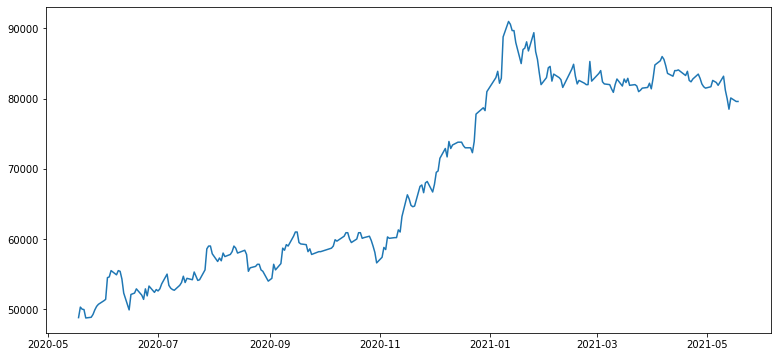

In [3]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plt.plot(ts)

In [4]:
def plot_rolling_statistics(timeseries, window):
    
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    orig = plt.plot(timeseries, color = 'blue', label = 'original')    # 원본
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')    # 이동평균
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')   # 이동표준편차
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

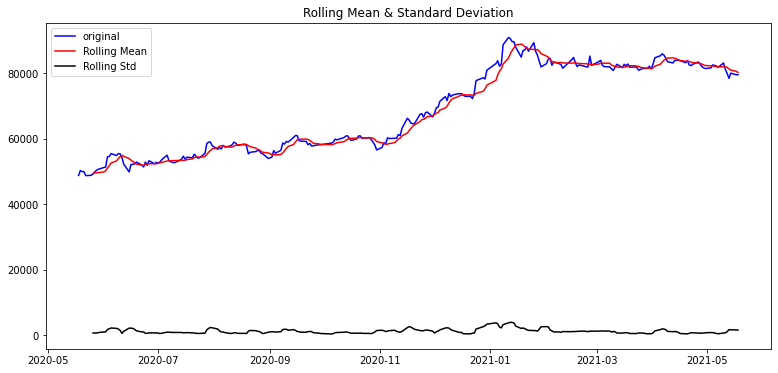

In [5]:
plot_rolling_statistics(ts, 7)

window를 일주일(7일)로 설정하여 이동평균, 이동표준편차를 구하였다. 이동표준편차는 큰 변동이 없으나 이동평균의 변화가 크다. 로그 변환을 진행했을 때 stationary 면에서 큰 차이가 없을 것으로 예상된다.

### 2) 정량적 Augmented Dickey-Fuller Test

* Augmented Dickey-Fuller Test(ADF Test): 시계열의 안정성(stationary) 테스트    
$t-p$ 시점까지의 차분 경향성을 나타내는 식($y_t = c + \beta t + \alpha y_{t-1} + \phi_1 \nabla y_{t-1} + ... + \phi_p \nabla y_{t-p} + e_t$)에서 regression을 통해 $\alpha$를 추정한 다음, 검정통계량($\alpha$)이 Critical Value(임계값)보다 작거나 p-value가 설정한 유의수준보다 작다면 stationary 시계열로 판정한다.     
즉, 주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(자료에 단위근이 존재한다, $H_0: \alpha = 1$)을 세운 후, 귀무가설이 기각될 경우에는 시계열 데이터가 안정적이다라는 대립가설(자료에 단위근이 존재하지 않는다, $H_0 : \alpha ≠ 1$)을 채택한다.    

  * $c$: 시계열 데이터의 레벨        
  * $\beta$: 시계열 데이터의 추세항         
  * $\alpha$: 단위근을 가질 확률    




In [6]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  

    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [7]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


p-value가 상당히 높으므로 본 데이터는 시계열적으로 안정적이지 않다.

In [8]:
ts_log = np.log(ts)
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


이동 표본분산이 적었던 ts는 로그 변환 후에도 p-value가 많이 떨어지지 않는다.

### 3) 시계열 분해(Time Series Decomposition)와 Residual 안정성 확인

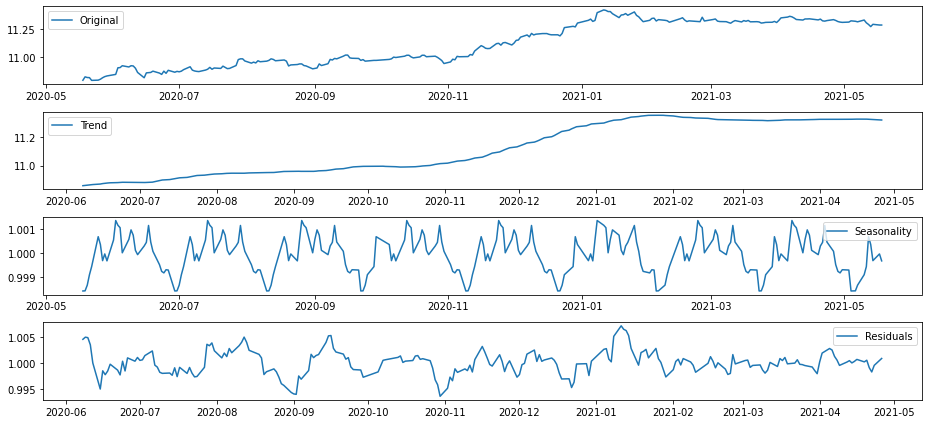

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend    # 추세
seasonal = decomposition.seasonal    # 계절성
residual = decomposition.resid    # 원본에서 추세와 계절성이 빠진 잔차 

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [10]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


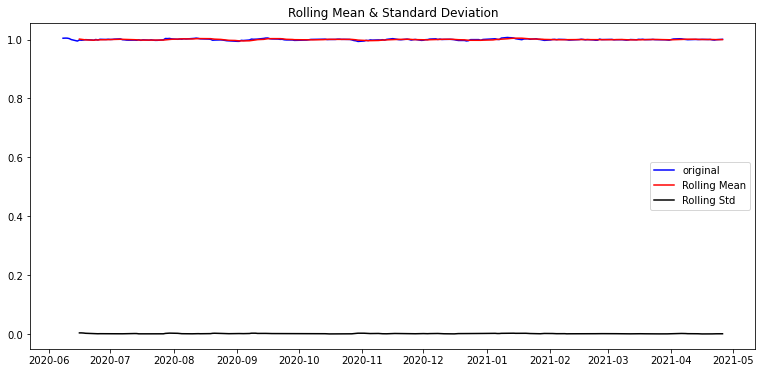

In [11]:
plot_rolling_statistics(residual, 7)

p-value가 충분히 작아져 residual이 시계열적으로 안정적이지 않다는 귀무가설을 기각할 수 있다. 시각적으로 표현하였을 때 역시 이동평균과 이동표준편차가 거의 일정한 값을 보이고 있음을 알 수 있다.

## 3. 적정 ARIMA 모수 찾기

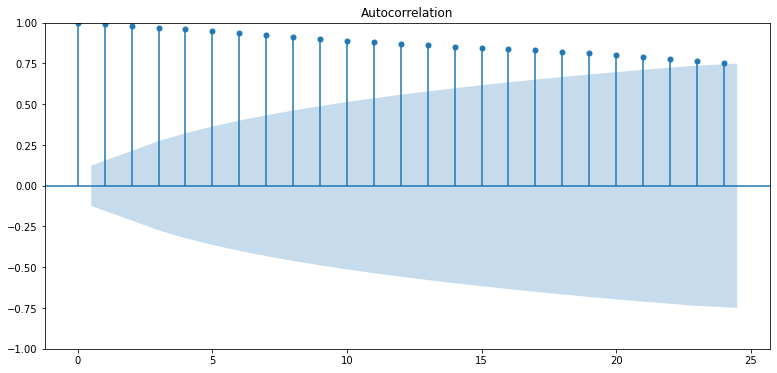

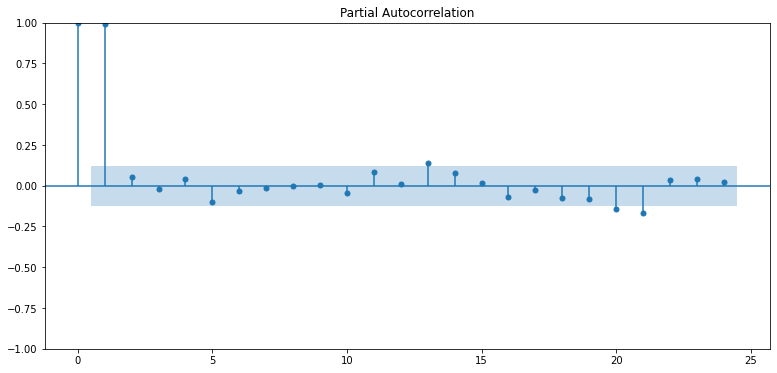

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

ACF가 점차적으로 감소하고, PACF는 시차 20 이후에 0에 가깝다. 또한 PACF는 점차 감소하는 그래프가 아니므로 파라미터는 p=21, q=0 으로 택한다.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


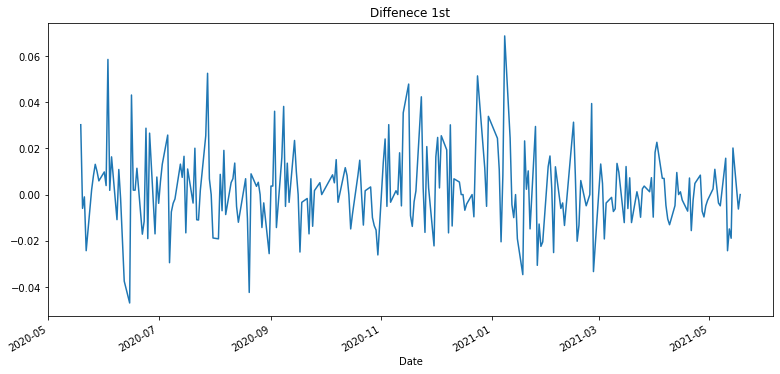

In [13]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Diffenece 1st')
augmented_dickey_fuller_test(diff_1)

1차 미분만으로도 충분히 안정화 상태를 보이므로 d=1로 택한다.

## 4. ARIMA 모델 훈련과 테스트

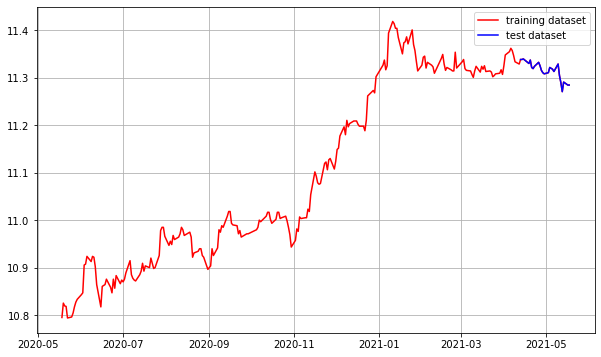

In [14]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [15]:
print(train_data.shape)
print(test_data.shape)

(225,)
(25,)


In [16]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(21,1,0))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(21, 1, 0)   Log Likelihood                 589.437
Date:                Thu, 17 Feb 2022   AIC                          -1134.875
Time:                        10:25:14   BIC                          -1059.819
Sample:                             0   HQIC                         -1104.578
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0380      0.070      0.540      0.589      -0.100       0.176
ar.L2         -0.0199      0.082     -0.242      0.809      -0.181       0.141
ar.L3         -0.0418      0.083     -0.507      0.6

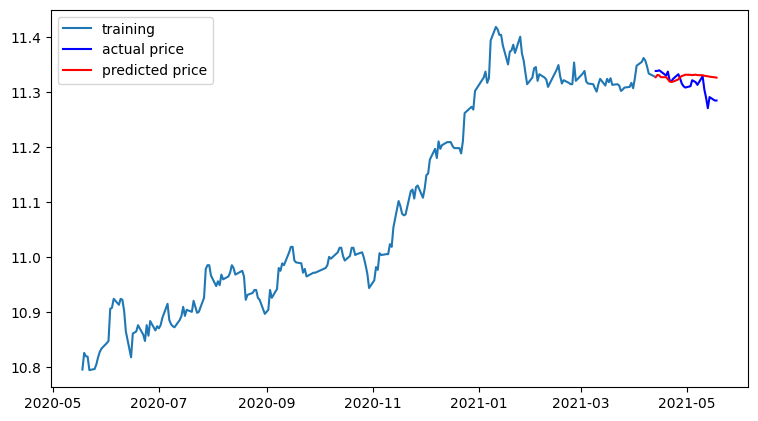

In [17]:
fc=fitted_m.forecast(len(test_data), alpha=0.05)
fc.index = test_data.index

plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc, c='r', label = 'predicted price')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3538196.6657617553
MAE:  1436.139390496299
RMSE:  1881.0094805082072
MAPE: 1.77%


MAPE 기준 1.77%로 오류율이 충분히 낮은 예측값을 얻었다.

## 5. 다른 주식 종목 예측해보기
앞서 진행한 삼성전자 주식 데이터가 1년치의 데이터였으므로, 그보다 짧거나 긴 기간에 대해서도 적절한 예측값이 나오는지 알아본다.
### 1) Amazon(3개월)

In [19]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/AMZN.csv'
df  = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates=True)
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2021-11-17    3549.000000
2021-11-18    3696.060059
2021-11-19    3676.570068
2021-11-22    3572.570068
2021-11-23    3580.040039
Name: Close, dtype: float64

In [20]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

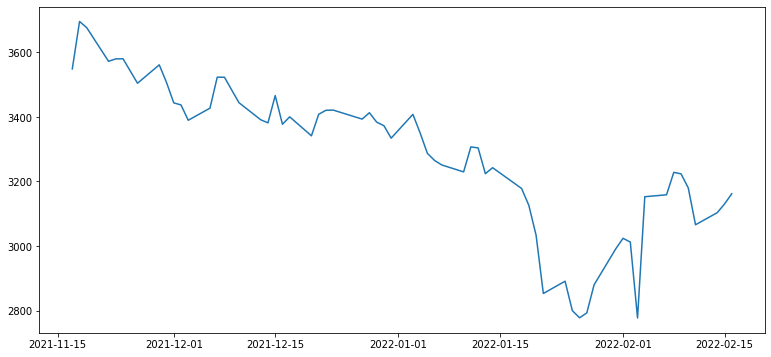

In [21]:
plt.plot(ts)

In [22]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -1.607320
p-value                         0.479915
#Lags Used                      0.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64


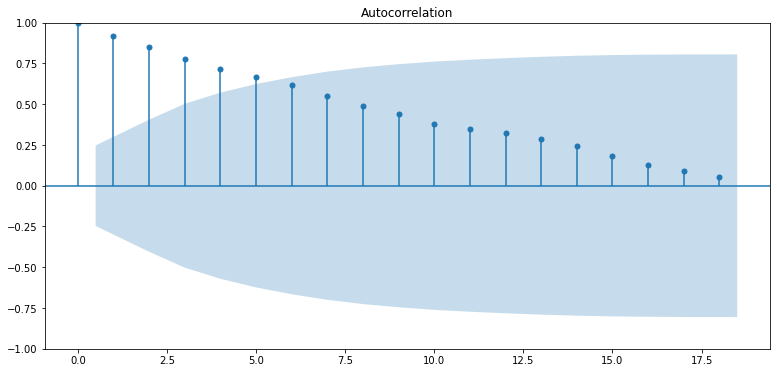

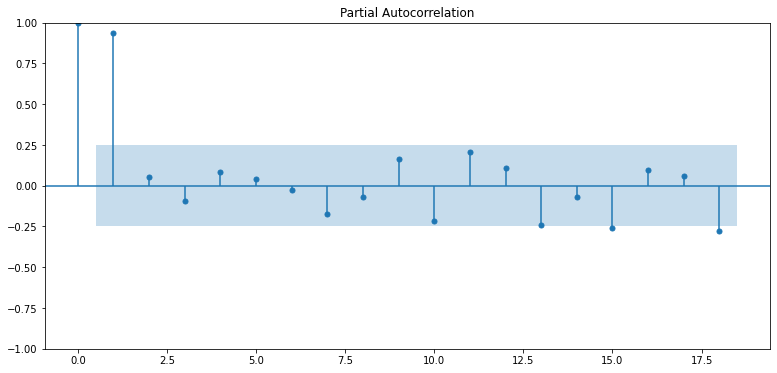

In [23]:
ts_log = np.log(ts)

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

In [24]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -9.458243e+00
p-value                        4.425043e-16
#Lags Used                     0.000000e+00
Number of Observations Used    6.100000e+01
Critical Value (1%)           -3.542413e+00
Critical Value (5%)           -2.910236e+00
Critical Value (10%)          -2.592745e+00
dtype: float64


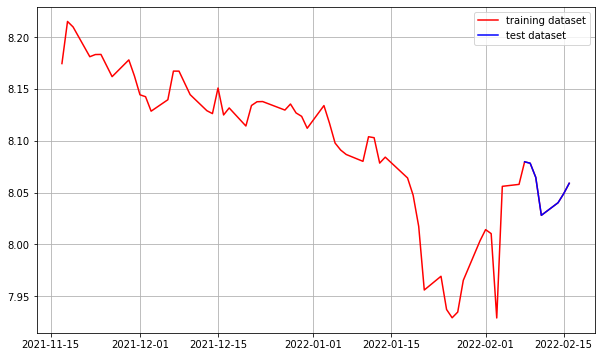

In [25]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

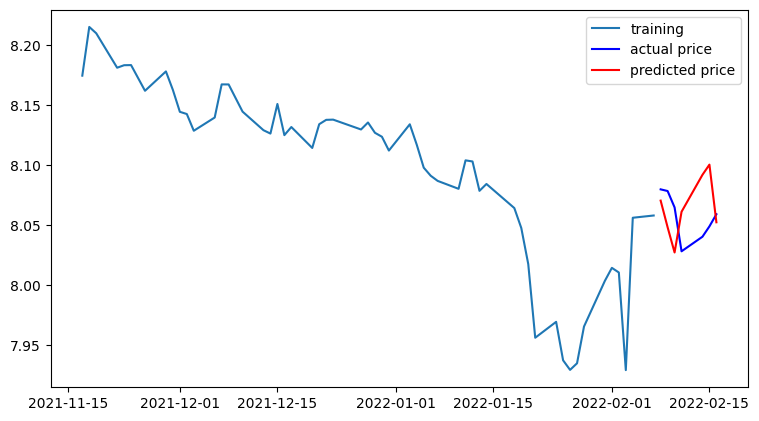

In [26]:
model = ARIMA(train_data, order=(18,1,0))
fitted_m = model.fit()
fc=fitted_m.forecast(len(test_data), alpha=0.05)
fc.index = test_data.index

plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc, c='r', label = 'predicted price')
plt.legend()
plt.show()

In [27]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  12732.891872421094
MAE:  99.51548055572019
RMSE:  112.84011641442548
MAPE: 3.17%


### 2) Disney(6개월)

In [28]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/DIS.csv'
df  = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates=True)
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2021-08-17    175.830002
2021-08-18    174.740005
2021-08-19    173.250000
2021-08-20    175.119995
2021-08-23    177.660004
Name: Close, dtype: float64

In [29]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

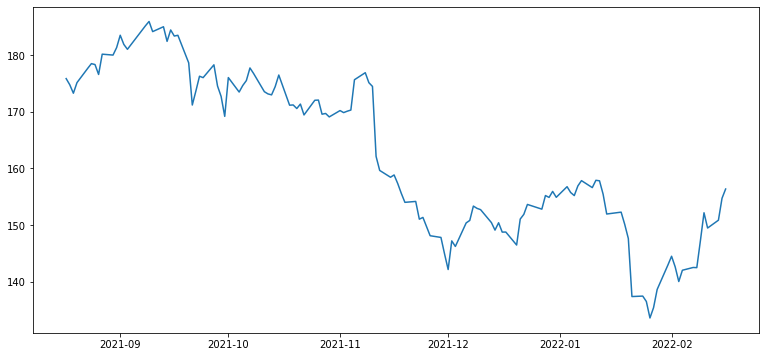

In [30]:
plt.plot(ts)

In [31]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.236947
p-value                          0.657503
#Lags Used                       0.000000
Number of Observations Used    127.000000
Critical Value (1%)             -3.482920
Critical Value (5%)             -2.884580
Critical Value (10%)            -2.579058
dtype: float64


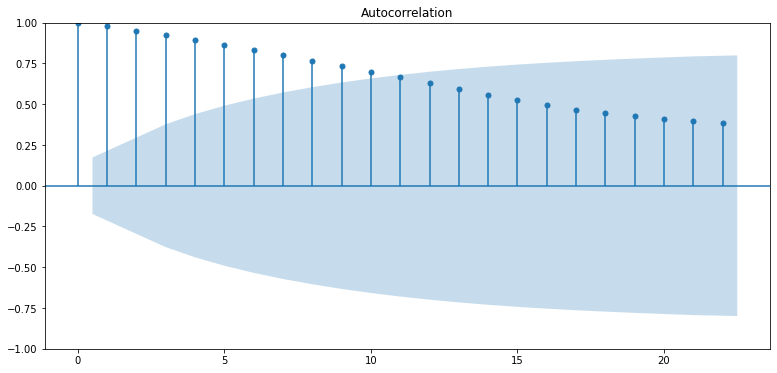

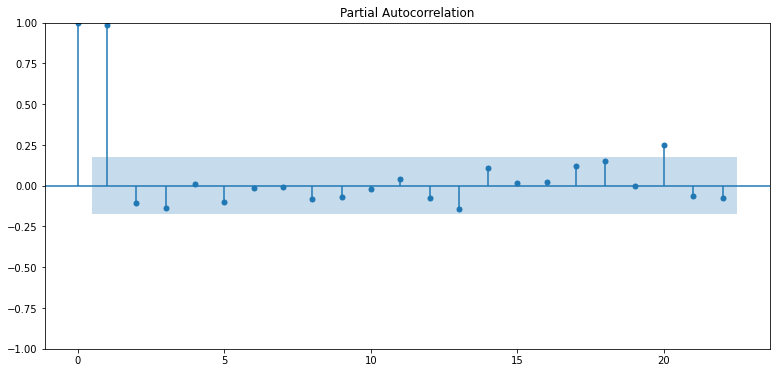

In [32]:
ts_log = np.log(ts)

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

In [33]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.035107e+01
p-value                        2.535929e-18
#Lags Used                     0.000000e+00
Number of Observations Used    1.260000e+02
Critical Value (1%)           -3.483346e+00
Critical Value (5%)           -2.884766e+00
Critical Value (10%)          -2.579156e+00
dtype: float64


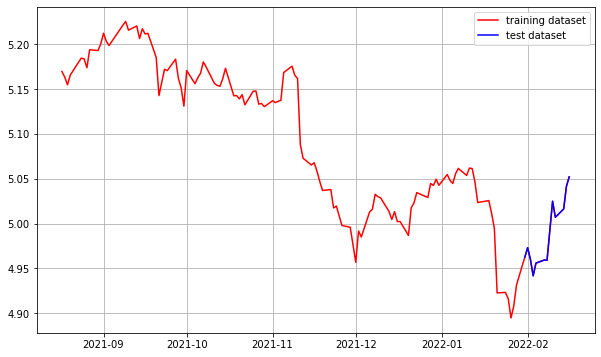

In [34]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

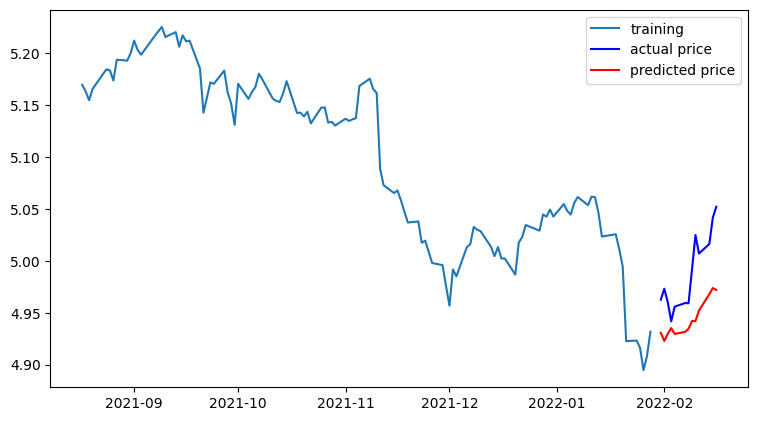

In [35]:
model = ARIMA(train_data, order=(20,1,0))
fitted_m = model.fit()
fc=fitted_m.forecast(len(test_data), alpha=0.05)
fc.index = test_data.index

plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc, c='r', label = 'predicted price')
plt.legend()
plt.show()

In [36]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  53.022428807984724
MAE:  6.486014366872774
RMSE:  7.281650143201383
MAPE: 4.35%


### 3) Netflix(5년)

In [37]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/NFLX.csv'
df  = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates=True)
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2017-02-17    142.220001
2017-02-21    142.600006
2017-02-22    143.860001
2017-02-23    142.779999
2017-02-24    143.250000
Name: Close, dtype: float64

In [38]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

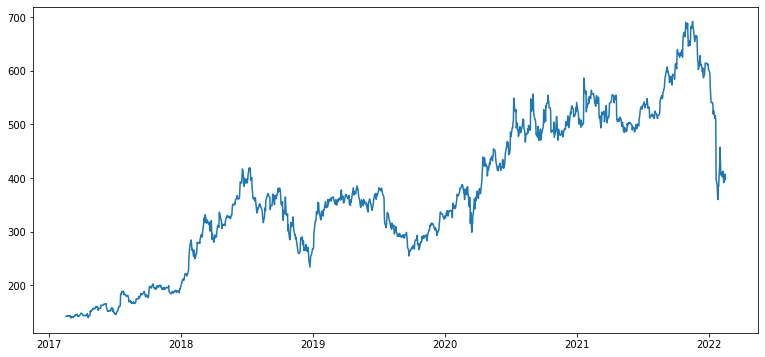

In [39]:
plt.plot(ts)

In [40]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                   -1.762847
p-value                           0.399057
#Lags Used                       22.000000
Number of Observations Used    1236.000000
Critical Value (1%)              -3.435652
Critical Value (5%)              -2.863881
Critical Value (10%)             -2.568016
dtype: float64


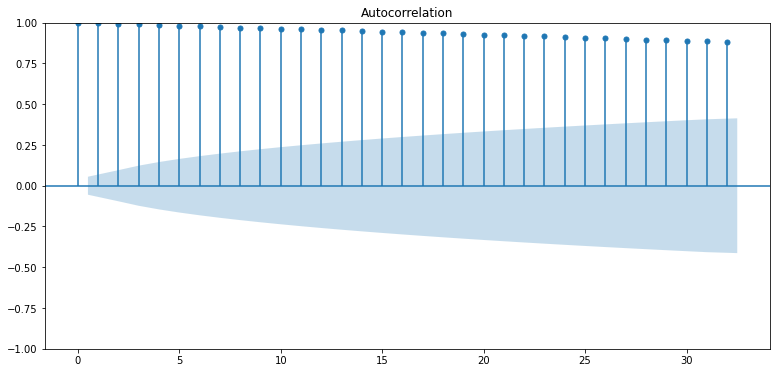

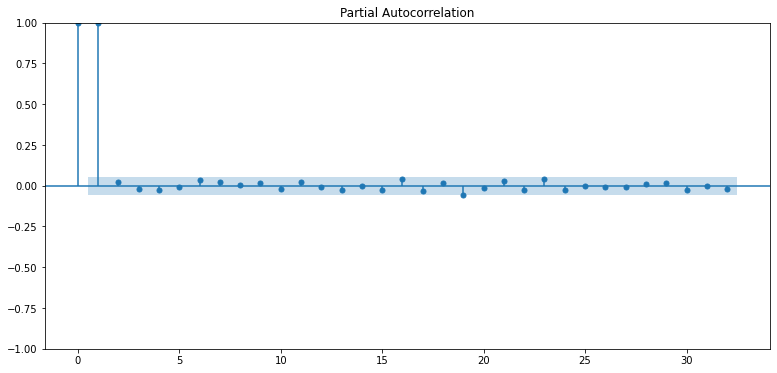

In [41]:
ts_log = np.log(ts)

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

In [42]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.558878e+01
p-value                        1.891717e-28
#Lags Used                     5.000000e+00
Number of Observations Used    1.252000e+03
Critical Value (1%)           -3.435584e+00
Critical Value (5%)           -2.863851e+00
Critical Value (10%)          -2.568001e+00
dtype: float64


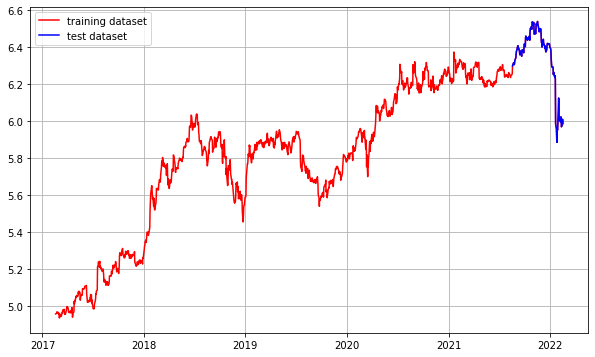

In [54]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

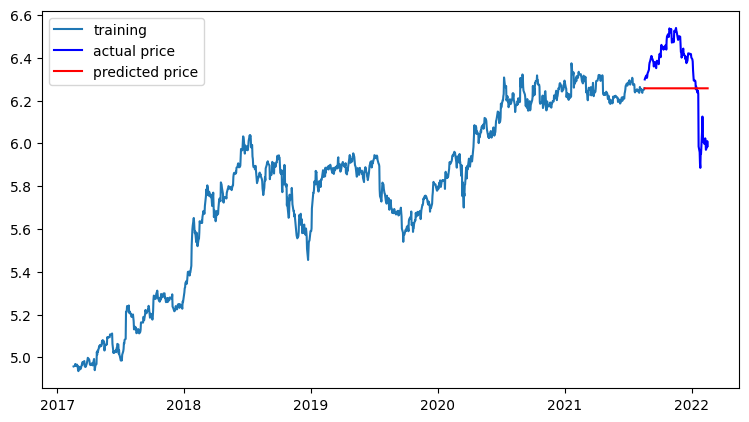

In [55]:
model = ARIMA(train_data, order=(1,1,0))
fitted_m = model.fit()
fc=fitted_m.forecast(len(test_data), alpha=0.05)
fc.index = test_data.index

plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc, c='r', label = 'predicted price')
plt.legend()
plt.show()

In [56]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  10677.471261146471
MAE:  94.1648470993896
RMSE:  103.33185017769918
MAPE: 16.63%


MAPE 오류율 기준으로 각 예측값의 오류율은 아마존(3개월): 3.17%, 디즈니(6개월): 4.35%, 삼성전자(1년): 1.77%, 넷플릭스(5년): 16.63%를 기록했다. 해당 결과만을 놓고 보면 데이터가 쌓인 기간에 비례해서 정확도가 오르는 것으로 기대하기는 어려울 것으로 보인다.

## 회고

* 선택한 모든 주식 데이터가 AR 모델의 형태였고, MA 모델의 형태는 나오지 않았다. 주식값이 항상 일정한 균형 수준을 유지할 것이라고 예측하는 관점이 주식 시계열을 AR로 모델링하는 관점이라는 설명에 의하면 주식값은 최근의 증감 패턴보다는 일반적으로 큰 균형 수준을 보이는 가격이라는 의미가 되는 듯 하다.
* 마지막 넷플릭스 데이터에서는 예측값이 거의 같은 값이 나왔다. 예측 범위가 5년치 데이터의 10%, 약 6개월간의 너무 많은 값을 알아내야 하는 셈이었으므로 오류가 많이 발생하는 것은 자연스러운 일이었을 수도 있으나, 학습한 범위가 약 54개월치의 많은 범위인데, 예측값이 거의 상수에 가깝게 나오는 것은 조금 의아했다. 일반적으로 '균형 수준'을 유지하는 것이 주식 가격 데이터라면 충분히 많은 양의 시계열 데이터가 축적되어 있을 때 결국 예측할 수 있는 값은 현상 유지라는 의미일까.....
* 통계학적 지식이 유난히 많이 필요한 exp였다. ARIMA 모델의 사용 방법 자체는 간단했지만, 토대가 되는 통계학 학습이 더 중요했던 exp가 아니었을까 생각해본다.